A simple GAN.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses, Input
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
import time
from IPython import display

# (x_train, _), (x_test, _) = fashion_mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
#
# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

(mn_x_train, mn_x_train_labels), (mn_x_test, test_labels) = mnist.load_data()

# sample_size = 10000
#
# mn_x_train = mn_x_train[:sample_size]
# mn_x_train_labels = mn_x_train_labels[:sample_size]

mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.
mn_x_train_labels = mn_x_train_labels.astype('float32')
mn_x_test_labels = test_labels.astype('float32')

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

# print(x_train.shape)

In [27]:
# # This method returns a helper function to compute cross entropy loss
# cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

class GAN(tf.keras.Model):
    """Generative Adversarial Network."""

    def __init__(self, gen_input_dim=100, generator_aim="ODD_EVEN"):
        super(GAN, self).__init__()
        self.gen_input_dim = gen_input_dim

        if generator_aim == "ODD_EVEN":
            num_labels = 2
        elif generator_aim == "SPECIFIC":
            num_labels = 10
        else:
            raise ValueError(f"generator_aim: {generator_aim} must be either ODD_EVEN or SPECIFIC")


        self.generator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(gen_input_dim,)),
                layers.Dense(7 * 7 * 256),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Reshape((7, 7, 256)),
                layers.Conv2DTranspose(128, 5, strides=1, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(64, 5, strides=2, padding='same'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Conv2DTranspose(1, 5, strides=2, padding='same', activation='sigmoid')
            ],
            name='generator'
        )

        self.num_labels = num_labels
        self.discriminator = GAN.create_multi_output_discriminator(num_labels)


        @tf.function
        def sample(self, eps=None):
            if eps is None:
                eps = tf.random.normal(shape=(100, self.latent_dim))
            return self.generator(eps, training=False)


    @staticmethod
    def create_multi_output_discriminator(num_labels = 2):
        """
        Creates a discriminator that takes in an image and a label and outputs a vector.

        Takes in input a flattened image, along with a vector concatenated with the label.

        :param num_labels: number of labels to choose from
        :return: model
        """
        image_input = Input(shape=(28,28,1), name='image_input')
        label_input = Input(shape=(num_labels,), name='label_input')

        flattened_image = layers.Flatten()(image_input)

        concatenated_inputs = layers.concatenate([flattened_image, label_input])

        discriminator = tf.keras.Sequential(
            [
                layers.InputLayer(input_shape=(28*28 + num_labels,)),  # Corrected input shape
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(2 + num_labels, activation='softmax')
            ]
        )
        output = discriminator(concatenated_inputs)

        return Model(inputs=[image_input, label_input], outputs=output, name='discriminator')


In [28]:
cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

# soft_max_cross_entropy = tf.nn.softmax_cross_entropy_with_logits()

# mean_squares = tf.keras.losses.MeanSquaredError()

class GAN_trainer():

    def __init__(self, train_images, train_labels, gen_input_dim=100, batch_size=256):
        self.gan = GAN(gen_input_dim)
        self.generator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
        self.gen_input_dim = gen_input_dim
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.gen_input_dim])
        self.batch_size = batch_size

        self.images_dataset = tf.data.Dataset.from_tensor_slices(train_images)
        self.labels_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

        self.dataset = tf.data.Dataset.zip((self.images_dataset, self.labels_dataset)).shuffle(train_images.shape[0]).batch(
            self.batch_size) # Combine images and labels into dataset.

        self.num_batches = train_images.shape[0] // self.batch_size
        self.image_labels = None

    def create_generator_input_and_labels(self, generator_aim="ODD_EVEN", batch_size=-1):
        """
        Creates generator input and labels.

        Input is a random vector with size determined by gen_input_dim and another label vector concanated with it. Looks roughly like:

        [random_vector, label_vector]

        :param generator_aim: aim of the generator, e.g. "ODD_EVEN" means its drying to distinguish between odd and even numbers. Used to decide how big the label vector should be.
        :return: generator input and labels created.
        """
        if batch_size == -1:
            batch_size = self.batch_size

        if generator_aim == "ODD_EVEN":
            generator_noise = tf.random.normal([batch_size, self.gen_input_dim - 2])
            generator_labels = GAN_trainer.random_one_hot_matrix(batch_size, 2)
            generator_input = tf.concat([generator_noise, generator_labels], axis=1)
            return generator_input, generator_labels
        elif generator_aim == "SPECIFIC":
            generator_noise = tf.random.normal([batch_size, self.gen_input_dim- 10])
            generator_labels = GAN_trainer.random_one_hot_matrix(batch_size, 10)
            generator_input = tf.concat([generator_noise, generator_labels], axis=1)
            return generator_input, generator_labels
        else:
            raise ValueError(f"Generator aim: '{generator_aim}' not recognized") # For my own sanity

    @tf.function
    def one_hot_labels(self, labels, generator_aim="ODD_EVEN"):
        """
        Creates the labels for the real images.

        Labels depend on what the generator is trying to do. E.g. create odd or even numbers or create specific numbers.

        :param labels: labels of the real images. Encoded as integer, e.g. 4, 6, 2
        :param generator_aim: aim of the generator, e.g. "ODD_EVEN" means its trying to distinguish between odd and even numbers
        :return: labels encoded as one-hot tensors
        """
        if generator_aim == "ODD_EVEN":
            even_mask = tf.equal(tf.math.mod(labels, 2), 0)
            odd_mask = tf.logical_not(even_mask)
            even_labels = tf.where(even_mask, tf.ones_like(labels), tf.zeros_like(labels))
            odd_labels = tf.where(odd_mask, tf.ones_like(labels), tf.zeros_like(labels))
            real_labels = tf.stack([even_labels, odd_labels], axis=-1)
        elif generator_aim == "SPECIFIC":
            real_labels = tf.one_hot(labels, depth=10)
        else:
            raise ValueError(f"Generator aim: '{generator_aim}' not recognized")  # For my own sanity

        return real_labels

    def discriminator_output_to_one_hot(self, discriminator_output):
        """
        Translates discriminator output to one_hot_encoding

        Not entirely sure if this function is necessary. You can more or less ignore it for now.
        :param discriminator_output:
        :return:
        """
        first_two = tf.argmax(discriminator_output[:, :2], axis=1)
        first_two = tf.expand_dims(first_two, axis=1)
        last_ones = tf.argmax(discriminator_output[:, 2:], axis=1)
        last_ones = tf.expand_dims(last_ones, axis=1)
        first_two = tf.cast(first_two, dtype=tf.int32)
        last_ones = tf.cast(last_ones, dtype=tf.int32) + 2
        indices = tf.concat([first_two, last_ones], axis=1)

        num_rows = tf.shape(indices)[0]
        row_range = tf.range(num_rows)
        row_indices = tf.tile(tf.expand_dims(row_range, 1), [1, tf.shape(indices)[1]])
        row_indices_flat = tf.reshape(row_indices, [-1])
        col_indices_flat = tf.reshape(indices, [-1])
        expanded_indices = tf.stack([row_indices_flat, col_indices_flat], axis=-1)
        expanded_indices = tf.cast(expanded_indices, dtype=tf.int64)

        output_size = tf.shape(discriminator_output)[0]

        values = [1 for _ in range(2 * output_size)]


        shape = tf.cast(tf.shape(discriminator_output), "int64")
        output = tf.SparseTensor(expanded_indices, values, shape)

        # print(output._numpy())

        dense = tf.sparse.to_dense(output)

        return dense

    @tf.function
    def train_step(self, images, generator_aim="ODD_EVEN", this_batch_size=-1):
        """
        Completes a training step

        :param images: images to train on
        :param generator_aim: aim of the generator, e.g. "ODD_EVEN" means its drying to distinguish between odd and even numbers
        :param this_batch_size: batch size of this step. If -1, the default batch size of the trainer is used (256). Since the final batch can have less than 256 els, this is necessary.
        :return: generator loss and discriminator loss
        """
        image_labels = self.one_hot_labels(self.image_labels, generator_aim)

        generator_input, generator_labels = self.create_generator_input_and_labels(generator_aim, this_batch_size)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.gan.generator(generator_input, training=True)

            disc_real_output = self.gan.discriminator([images, image_labels], training=True)
            disc_gen_output = self.gan.discriminator([generated_images, generator_labels], training=True)

            gen_loss = self.generator_loss(disc_gen_output, generator_labels)
            disc_loss = self.discriminator_loss(disc_real_output, disc_gen_output, image_labels, generator_labels)

            gradients_of_generator = gen_tape.gradient(gen_loss, self.gan.generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, self.gan.discriminator.trainable_variables)

            self.generator_optimizer.apply_gradients(
                zip(gradients_of_generator, self.gan.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(gradients_of_discriminator, self.gan.discriminator.trainable_variables))

        return gen_loss, disc_loss

    @tf.function
    def discriminator_loss(self, real_output, generator_output, real_labels, generator_labels, num_labels=2):
        """
        Computes the loss function for the discriminator.

        Uses cross entropy loss.

        :param real_output: Discriminator's output for real images.
        :param generator_output: Discriminator's output for generated images.
        :param real_labels: One-hot encoded labels for real images.
        :param generator_labels: One-hot encoded labels for generated images.
        :param num_labels: Number of classes in the discriminator (e.g., 2 for "ODD_EVEN").
        :return: The computed discriminator loss.
        """

        input_size = tf.shape(real_output)[0]

        real_legit_label_row = tf.constant([0, 1], dtype=tf.float32) # Changed from [0, num_labels]
        gen_legit_label_row = tf.constant([1, 0], dtype=tf.float32)

        real_expected_legit_labels = tf.tile(tf.expand_dims(real_legit_label_row, axis=0), [input_size, 1])
        gen_expected_legit_labels = tf.tile(tf.expand_dims(gen_legit_label_row, axis=0), [input_size, 1])
        real_expected_legit_labels = tf.cast(real_expected_legit_labels, tf.float32)
        gen_expected_legit_labels = tf.cast(gen_expected_legit_labels, tf.float32)

        real_output_legit_labels = real_output[:, :2]
        gen_output_legit_labels = generator_output[:, :2]
        real_output_legit_labels = tf.cast(real_output_legit_labels, tf.float32)
        gen_output_legit_labels = tf.cast(gen_output_legit_labels, tf.float32)

        real_legit_loss = cat_cross_entropy(real_expected_legit_labels, real_output_legit_labels)
        gen_legit_loss = cat_cross_entropy(gen_expected_legit_labels, gen_output_legit_labels)

        expected_real_output = tf.concat([real_legit_labels, real_labels], axis=1)
        expected_generator_output = tf.concat([gen_legit_labels, generator_labels], axis=1)

        real_output = tf.cast(real_output, tf.float32)
        generator_output = tf.cast(generator_output, tf.float32)
        expected_real_output = tf.cast(expected_real_output, tf.float32)
        expected_generator_output = tf.cast(expected_generator_output, tf.float32)

        real_loss = cat_cross_entropy(expected_real_output, real_output)
        fake_loss = cat_cross_entropy(expected_generator_output, generator_output)
        total_loss = real_loss + fake_loss
        return total_loss

    @tf.function
    def generator_loss(self, discriminator_output, generator_labels, num_labels=2):
        """
        Computes the loss function for the generator.

        Takes in the output of the descriminator from the generated images and the labels that the generator was trying to create.

        :param discriminator_output: output from the descriminator, I.e. If the discriminator believes the images are legit or not
        :return: the cross entropy loss
        """
        output_size = tf.shape(discriminator_output)[0]

        expected_true_false = tf.constant([0, 1], dtype=tf.float32)
        repeated_rows = tf.repeat(tf.expand_dims(expected_true_false, axis=0), repeats=output_size, axis=0)
        expected_output = tf.concat([repeated_rows, generator_labels], axis=1)
        discriminator_output = tf.cast(discriminator_output, "float32")

        # print(expected_output)
        return cat_cross_entropy(expected_output, discriminator_output)

    @staticmethod
    def random_one_hot_matrix(num_rows, num_cols):
        """
        Creates a random one hot matrix

        :param num_rows: number of rows in the matrix
        :param num_cols: number of columns in the matrix
        :return: a random one hot matrix
        """
        return tf.one_hot(tf.random.uniform(shape=(num_rows,), minval=0, maxval=num_cols, dtype=tf.int32), num_cols)

    def train(self, epochs):
        self.gen_losses = []
        self.disc_losses = []
        for epoch in range(epochs):
            start = time.time()

            gen_loss = 0
            disc_loss = 0

            print(f"Epoch {epoch + 1}/{epochs}")

            i = 0

            for batch in self.dataset:
                # print(f"Epoch {epoch + 1}/{epochs}, Batch {i}/{self.num_batches}", flush=True)

                image_batch, label_batch = batch
                this_batch_size = tf.shape(image_batch)[0]

                self.image_labels = label_batch
                gl, dl = self.train_step(image_batch, this_batch_size=this_batch_size)
                # print("here 4")
                gen_loss += gl
                disc_loss += dl
                i += 1

            self.gen_losses.append(gen_loss / self.num_batches)
            self.disc_losses.append(disc_loss / self.num_batches)

            # Produce images for the GIF as we go
            display.clear_output(wait=True)
            print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

            self.generate_and_save_images(epoch)

        # Generate after the final epoch
        display.clear_output(wait=True)
        self.generate_and_save_images(epochs)

    def generate_and_save_images(self, epoch):
        generator_input, generator_labels = self.create_generator_input_and_labels(batch_size=16)

        predictions = self.gan.generator(generator_input, training=False)

        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1) # TODO, add subtitles to subplots, so we know what the generator is trying to create.
            plt.imshow(predictions[i, :, :, 0], cmap='gray')

        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

        fig, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10, 5))
        ax1.plot(self.gen_losses, label='Generator Loss')
        ax1.plot(self.disc_losses, label='Discriminator Loss')
        ax1.legend()
        plt.show()

Time for epoch 15 is 62.15395212173462 sec


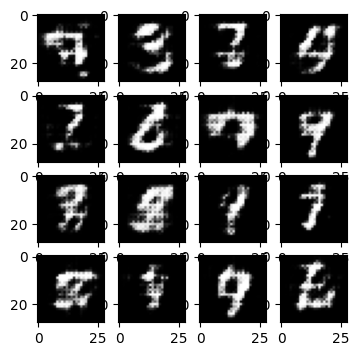

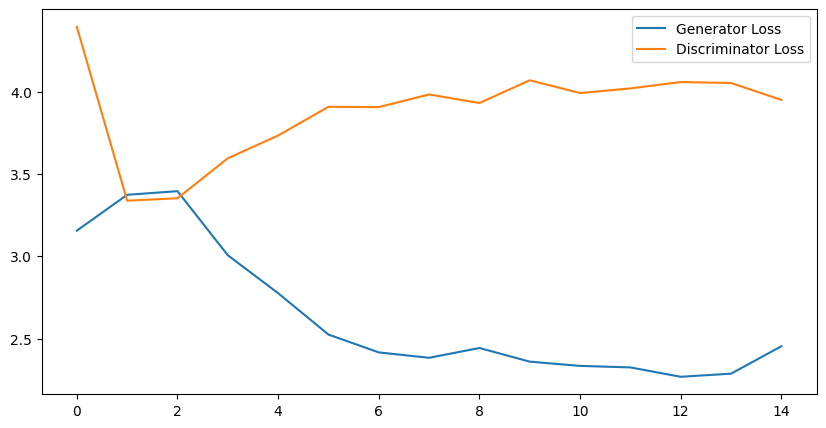

Epoch 16/50


In [ ]:
gan = GAN_trainer(mn_x_train, mn_x_train_labels)

gan.train(epochs=50)

In [ ]:
print(tf.data.experimental.cardinality(gan.dataset).numpy())

In [ ]:
zeros_tensor = tf.constant([0, 2], dtype=tf.float32)

print(gan.image_labels.shape)

for set in gan.dataset:
    images, labels = set
    print(labels.shape)
    break

# tf.tile(tf.expand_dims(zeros_tensor, axis=0), [256, 1])

In [ ]:
tensor = tf.constant([
    [9.1, 5, 6, 3, 2, 1],
    [0, 100, 6, 3, 9, 2],
    [11, 2, 7, 4, 0, 10]
])

# print(tensor[tf.gather(tensor, tf.argsort(tensor, axis=1))])

# print(tf.argmax(tensor[:, 2:]))

In [ ]:
tf.gather_nd(tensor, tf.argsort(tensor[:, :2], axis=1))

In [ ]:
first_two = tf.argmax(tensor[:, :2], axis=1)
first_two = tf.expand_dims(first_two, axis=1)
last_ones = tf.argmax(tensor[:, 2:], axis=1)
last_ones = tf.expand_dims(last_ones, axis=1)
first_two = tf.cast(first_two, dtype=tf.int32)
last_ones = tf.cast(last_ones, dtype=tf.int32) + 2

In [ ]:
indices = tf.concat([first_two, last_ones], axis=1)

In [ ]:
import tensorflow as tf
num_rows = tf.shape(indices)[0]
row_range = tf.range(num_rows)
row_indices = tf.tile(tf.expand_dims(row_range, 1), [1, tf.shape(indices)[1]])
row_indices_flat = tf.reshape(row_indices, [-1])
col_indices_flat = tf.reshape(indices, [-1])
expanded_indices = tf.stack([row_indices_flat, col_indices_flat], axis=-1)
expanded_indices = tf.cast(expanded_indices, dtype=tf.int64)

In [ ]:
values = [1] * 6
shape = [3, 6]
delta = tf.SparseTensor(expanded_indices, values, shape)

In [ ]:
delta

In [ ]:
tf.sparse.to_dense(delta)

In [ ]:
tf.cast(tf.shape(delta), "int64")

In [ ]:
tf.shape(delta)

In [ ]:
discriminator_output = tf.constant([
    [9.1, 5, 6, 3, 2, 1],
    [0, 100, 6, 3, 9, 2],
    [11, 2, 7, 4, 0, 10]
])

first_two = tf.argmax(discriminator_output[:, :2], axis=1)
first_two = tf.expand_dims(first_two, axis=1)
last_ones = tf.argmax(discriminator_output[:, 2:], axis=1)
last_ones = tf.expand_dims(last_ones, axis=1)
first_two = tf.cast(first_two, dtype=tf.int32)
last_ones = tf.cast(last_ones, dtype=tf.int32) + 2
indices = tf.concat([first_two, last_ones], axis=1)

num_rows = tf.shape(indices)[0]
row_range = tf.range(num_rows)
row_indices = tf.tile(tf.expand_dims(row_range, 1), [1, tf.shape(indices)[1]])
row_indices_flat = tf.reshape(row_indices, [-1])
col_indices_flat = tf.reshape(indices, [-1])
expanded_indices = tf.stack([row_indices_flat, col_indices_flat], axis=-1)
expanded_indices = tf.cast(expanded_indices, dtype=tf.int64)

output_size = tf.shape(discriminator_output)[0]

values = [1] * 2 * output_size
shape = tf.cast(tf.shape(discriminator_output), "int64")
output = tf.SparseTensor(expanded_indices, values, shape)

print(output._numpy())

dense = tf.sparse.to_dense(output)


In [ ]:
tf.shape(discriminator_output)[0]

In [ ]:
values.numpy()

In [ ]:
values = [1 for i in range(2 * output_size)]

In [ ]:
values

In [ ]:
values.numpy()

In [ ]:
discriminator_output.dtype

In [ ]:
# Original row
original_row = tf.constant([0, 1], dtype=tf.float32)

# Repeat the row three times
repeated_rows = tf.repeat(tf.expand_dims(original_row, axis=0), repeats=3, axis=0)

repeated_rows
